In [1]:
!pip install -q torch_snippets
!wget -q https://www.dropbox.com/s/ua1rr8btkmpqjxh/face-detection.zip
!unzip -q face-detection.zip

     |████████████████████████████████| 43 kB 686 kB/s 
     |████████████████████████████████| 57 kB 4.0 MB/s 
     |████████████████████████████████| 10.1 MB 26.8 MB/s 
     |████████████████████████████████| 214 kB 49.6 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 
     |████████████████████████████████| 51 kB 6.0 MB/s 


In [2]:
import time
from torch_snippets import *
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
import glob
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class SiameseDataset(Dataset):
    def __init__(self, folder, transform):
        self.folder = folder
        self.transform = transform
        self.items = Glob(f'{self.folder}/*/*')
    def __len__(self):
        return len(self.items)
    def __getitem__(self, ix):
        itemA = self.items[ix]
        person = fname(parent(itemA))
        same_person = randint(2)
        if same_person:
            itemB = choose(Glob(f'{self.folder}/{person}/*'))
        else:
            while True:
                itemB = choose(self.items)
                if (person != fname(parent(itemB))):
                    break
        
        imgA = read(itemA)
        imgB = read(itemB)

        imgA = self.transform(imgA)
        imgB = self.transform(imgB)

        return imgA, imgB, np.array([1 - same_person])

In [4]:
from torchvision import transforms

trn_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(5, (0.01,0.2),
                            scale=(0.9,1.1)),
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

val_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

trn_ds = SiameseDataset(folder="/content/data/faces/training/", transform=trn_tfms)
val_ds = SiameseDataset(folder="/content/data/faces/testing/", transform=val_tfms)

trn_dl = DataLoader(trn_ds, shuffle=True, batch_size=64)
val_dl = DataLoader(val_ds, shuffle=True, batch_size=1, num_workers=6)

2021-12-01 12:37:51.745 | INFO     | torch_snippets.paths:inner:24 - 370 files found at /content/data/faces/training//*/*
2021-12-01 12:37:51.754 | INFO     | torch_snippets.paths:inner:24 - 30 files found at /content/data/faces/testing//*/*
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1, padding_mode='reflect'),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
    )

In [6]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            convBlock(1,4),
            convBlock(4,8),
            convBlock(8,8),
            nn.Flatten(),
            nn.Linear(8*100*100, 500), 
            nn.ReLU(inplace=True),
            nn.Linear(500, 500), 
            nn.ReLU(inplace=True),
            nn.Linear(500, 5)
        )

    def forward(self, input1, input2):
        output1 = self.features(input1)
        output2 = self.features(input2)
        return output1, output2

In [7]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super().__init__()
        self.margin = margin
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        acc = ((euclidean_distance > 0.6) == label).float().mean()
        return loss_contrastive, acc

In [8]:
def train_batch(model, data, optimizer, criterion):
    imgsA, imgsB, labels = [t.to(device) for t in data]
    optimizer.zero_grad()
    codesA, codesB = model(imgsA, imgsB)
    loss, acc = criterion(codesA, codesB, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

In [9]:
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001)

In [10]:
n_epochs = 200
Accuracy = []
Loss = []
for epoch in range(n_epochs):
    print(epoch)
    batch_acc, batch_loss = [], []
    for i, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        batch_loss.append(loss)
        batch_acc.append(acc)
    Accuracy.append(np.mean(batch_acc))
    Loss.append(np.mean(batch_loss))
    if (epoch == 10):
        optimizer = optim.Adam(model.parameters(), lr= 0.0005)

2021-12-01 12:38:08.390 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:38:08.430 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:38:08.450 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:38:08.458 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:38:08.466 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:38:08.475 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:38:08.481 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:38:08.493 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:38

0


2021-12-01 12:38:08.582 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:38:08.593 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:38:08.598 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:38:08.605 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:38:08.612 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:38:08.618 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:38:08.626 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:38:08.634 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:38:

1


2021-12-01 12:38:11.325 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:38:11.332 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:38:11.338 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:38:11.353 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:38:11.364 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:38:11.372 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:38:11.377 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:38:11.387 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:38:1

2


2021-12-01 12:38:13.722 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:38:13.735 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:38:13.747 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:38:13.757 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:38:13.763 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:38:13.773 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:38:13.780 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:38:13.786 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:38:

3


2021-12-01 12:38:16.126 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:38:16.136 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:38:16.142 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:38:16.151 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:38:16.156 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:38:16.165 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:38:16.173 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:38:16.184 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:38:1

4


2021-12-01 12:38:18.474 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:38:18.480 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:38:18.488 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:38:18.497 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:38:18.503 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:38:18.509 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:38:18.515 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:38:18.521 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:38:

5


2021-12-01 12:38:20.901 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:38:20.910 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:38:20.916 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:38:20.923 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:38:20.931 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:38:20.941 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:38:20.947 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:38:20.955 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:38

6


2021-12-01 12:38:23.343 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:38:23.356 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:38:23.364 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:38:23.372 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:38:23.515 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:38:23.528 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:38:23.535 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:38:23.541 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:38:

7


2021-12-01 12:38:25.682 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:38:25.688 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:38:25.695 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:38:25.711 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:38:25.721 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:38:25.854 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:38:25.868 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:38:25.883 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:38

8


2021-12-01 12:38:27.983 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:38:27.996 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:38:28.003 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:38:28.019 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:38:28.031 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:38:28.037 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:38:28.045 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:38:28.054 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:38:

9


2021-12-01 12:38:30.309 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:38:30.317 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:38:30.322 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:38:30.344 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:38:30.357 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:38:30.366 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:38:30.377 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:38:30.384 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:38:3

10


2021-12-01 12:38:32.756 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:38:32.763 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:38:32.769 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:38:32.776 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:38:32.787 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:38:32.794 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:38:32.803 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:38:32.812 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:38:3

11


2021-12-01 12:38:35.240 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:38:35.249 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:38:35.259 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:38:35.266 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:38:35.278 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:38:35.311 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:38:35.321 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:38:35.327 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:38

12


2021-12-01 12:38:37.615 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:38:37.627 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:38:37.635 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:38:37.645 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:38:37.654 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:38:37.662 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:38:37.669 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:38:37.677 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:38:

13


2021-12-01 12:38:40.065 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:38:40.082 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:38:40.099 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:38:40.108 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:38:40.242 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:38:40.259 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:38:40.269 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:38:40.275 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:38

14


2021-12-01 12:38:42.565 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:38:42.584 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:38:42.596 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:38:42.602 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:38:42.614 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:38:42.620 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:38:42.626 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:38:42.634 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:38

15


2021-12-01 12:38:44.979 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:38:45.004 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:38:45.017 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:38:45.023 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:38:45.029 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:38:45.035 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:38:45.165 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:38:45.175 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:38:4

16


2021-12-01 12:38:47.343 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:38:47.349 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:38:47.355 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:38:47.360 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:38:47.371 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:38:47.381 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:38:47.394 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:38:47.403 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:38:

17


2021-12-01 12:38:49.686 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:38:49.694 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:38:49.706 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:38:49.712 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:38:49.723 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:38:49.732 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:38:49.738 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:38:49.750 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:38:4

18


2021-12-01 12:38:52.102 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:38:52.136 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:38:52.149 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:38:52.161 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:38:52.170 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:38:52.176 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:38:52.181 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:38:52.188 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:38:

19


2021-12-01 12:38:54.488 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:38:54.503 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:38:54.512 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:38:54.538 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:38:54.684 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:38:54.693 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:38:54.702 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:38:54.708 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:38

20


2021-12-01 12:38:56.934 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:38:56.940 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:38:56.948 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:38:56.956 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:38:56.961 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:38:56.966 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:38:56.972 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:38:56.977 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:38

21


2021-12-01 12:38:59.442 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:38:59.452 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:38:59.460 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:38:59.475 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:38:59.487 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:38:59.497 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:38:59.504 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:38:59.512 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:38:59

22


2021-12-01 12:39:01.848 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:39:01.854 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:39:01.859 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:39:01.873 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:39:01.882 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:39:01.895 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:39:02.036 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:39:02.041 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:39:0

23


2021-12-01 12:39:04.229 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:39:04.236 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:39:04.243 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:39:04.256 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:39:04.265 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:39:04.273 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:39:04.403 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:39:04.413 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:39:0

24


2021-12-01 12:39:06.537 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:39:06.548 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:39:06.561 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:39:06.569 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:39:06.583 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:39:06.590 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:39:06.597 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:39:06.603 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:39:

25


2021-12-01 12:39:08.918 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:39:08.928 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:39:08.933 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:39:08.944 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:39:08.956 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:39:08.965 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:39:08.972 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:39:08.980 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:39:0

26


2021-12-01 12:39:11.271 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:39:11.292 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:39:11.304 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:39:11.312 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:39:11.324 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:39:11.342 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:39:11.479 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:39:11.486 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:39:

27


2021-12-01 12:39:13.551 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:39:13.563 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:39:13.573 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:39:13.581 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:39:13.600 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:39:13.609 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:39:13.621 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:39:13.629 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:39

28


2021-12-01 12:39:16.038 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:39:16.044 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:39:16.050 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:39:16.058 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:39:16.069 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:39:16.077 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:39:16.083 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:39:16.092 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:39:1

29


2021-12-01 12:39:18.407 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:39:18.414 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:39:18.420 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:39:18.430 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:39:18.438 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:39:18.444 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:39:18.452 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:39:18.460 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:39

30


2021-12-01 12:39:20.848 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:39:20.856 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:39:20.864 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:39:20.879 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:39:20.889 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:39:20.897 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:39:20.905 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:39:20.915 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:39:

31


2021-12-01 12:39:23.403 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:39:23.412 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:39:23.420 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:39:23.426 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:39:23.432 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:39:23.442 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:39:23.448 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:39:23.454 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:39:

32


2021-12-01 12:39:25.870 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:39:25.875 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:39:25.888 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:39:25.896 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:39:25.917 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:39:25.925 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:39:25.935 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:39:25.942 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:39

33


2021-12-01 12:39:28.371 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:39:28.391 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:39:28.400 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:39:28.408 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:39:28.422 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:39:28.435 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:39:28.444 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:39:28.449 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:39:28

34


2021-12-01 12:39:30.890 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:39:30.898 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:39:30.903 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:39:30.912 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:39:30.920 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:39:30.927 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:39:30.934 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:39:30.945 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:39:3

35


2021-12-01 12:39:33.316 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:39:33.323 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:39:33.330 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:39:33.336 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:39:33.346 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:39:33.365 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:39:33.372 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:39:33.381 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:39:

36


2021-12-01 12:39:35.771 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:39:35.777 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:39:35.785 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:39:35.793 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:39:35.799 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:39:35.809 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:39:35.818 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:39:35.824 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:39:

37


2021-12-01 12:39:38.191 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:39:38.197 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:39:38.204 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:39:38.223 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:39:38.230 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:39:38.237 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:39:38.244 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:39:38.255 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:39:

38


2021-12-01 12:39:40.696 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:39:40.704 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:39:40.712 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:39:40.724 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:39:40.730 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:39:40.737 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:39:40.742 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:39:40.749 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:39:

39


2021-12-01 12:39:43.195 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:39:43.211 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:39:43.218 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:39:43.224 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:39:43.230 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:39:43.235 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:39:43.241 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:39:43.250 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:39:

40


2021-12-01 12:39:45.747 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:39:45.757 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:39:45.768 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:39:45.775 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:39:45.790 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:39:45.802 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:39:45.809 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:39:45.815 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:39:4

41


2021-12-01 12:39:48.325 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:39:48.333 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:39:48.339 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:39:48.348 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:39:48.354 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:39:48.362 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:39:48.368 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:39:48.376 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:39:4

42


2021-12-01 12:39:50.830 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:39:50.839 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:39:50.848 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:39:50.858 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:39:50.869 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:39:50.880 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:39:50.896 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:39:50.912 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:39:

43


2021-12-01 12:39:53.361 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:39:53.367 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:39:53.380 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:39:53.385 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:39:53.396 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:39:53.401 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:39:53.407 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:39:53.543 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:39:

44


2021-12-01 12:39:55.837 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:39:55.848 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:39:55.854 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:39:55.860 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:39:55.866 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:39:55.872 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:39:55.880 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:39:55.889 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:39:

45


2021-12-01 12:39:58.466 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:39:58.476 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:39:58.483 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:39:58.492 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:39:58.500 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:39:58.507 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:39:58.520 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:39:58.533 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:39:

46


2021-12-01 12:40:01.037 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:40:01.046 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:40:01.052 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:40:01.065 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:40:01.090 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:40:01.098 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:40:01.107 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:40:01.112 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:40:

47


2021-12-01 12:40:03.447 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:40:03.453 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:40:03.459 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:40:03.472 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:40:03.478 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:40:03.484 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:40:03.489 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:40:03.494 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:40:0

48


2021-12-01 12:40:05.974 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:40:05.986 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:40:05.997 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:40:06.005 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:40:06.011 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:40:06.018 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:40:06.030 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:40:06.039 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:40

49


2021-12-01 12:40:08.364 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:40:08.377 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:40:08.387 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:40:08.396 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:40:08.402 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:40:08.408 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:40:08.414 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:40:08.425 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:40

50


2021-12-01 12:40:10.914 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:40:10.926 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:40:10.935 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:40:10.947 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:40:10.954 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:40:10.965 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:40:10.974 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:40:10.980 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:40:

51


2021-12-01 12:40:13.447 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:40:13.456 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:40:13.464 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:40:13.470 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:40:13.480 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:40:13.485 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:40:13.493 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:40:13.508 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:40

52


2021-12-01 12:40:15.839 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:40:15.850 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:40:15.860 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:40:15.866 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:40:15.873 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:40:15.886 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:40:15.895 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:40:15.901 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:40:

53


2021-12-01 12:40:18.364 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:40:18.370 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:40:18.379 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:40:18.391 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:40:18.400 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:40:18.412 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:40:18.423 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:40:18.430 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:40:1

54


2021-12-01 12:40:20.874 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:40:20.885 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:40:20.893 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:40:20.901 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:40:20.913 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:40:20.919 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:40:20.929 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:40:20.941 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:40:2

55


2021-12-01 12:40:23.324 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:40:23.331 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:40:23.336 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:40:23.345 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:40:23.351 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:40:23.357 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:40:23.367 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:40:23.375 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:40:2

56


2021-12-01 12:40:25.866 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:40:25.873 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:40:25.879 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:40:25.885 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:40:25.897 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:40:25.906 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:40:25.912 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:40:25.922 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:40:2

57


2021-12-01 12:40:28.470 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:40:28.481 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:40:28.488 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:40:28.496 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:40:28.522 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:40:28.535 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:40:28.543 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:40:28.556 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:40:2

58


2021-12-01 12:40:31.064 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:40:31.071 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:40:31.077 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:40:31.100 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:40:31.110 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:40:31.123 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:40:31.134 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:40:31.145 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:40:

59


2021-12-01 12:40:33.585 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:40:33.591 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:40:33.601 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:40:33.625 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:40:33.634 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:40:33.646 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:40:33.659 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:40:33.670 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:40:

60


2021-12-01 12:40:36.013 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:40:36.023 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:40:36.029 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:40:36.034 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:40:36.042 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:40:36.049 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:40:36.062 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:40:36.074 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:40:

61


2021-12-01 12:40:38.490 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:40:38.498 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:40:38.504 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:40:38.512 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:40:38.518 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:40:38.524 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:40:38.531 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:40:38.537 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:40:3

62


2021-12-01 12:40:40.988 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:40:40.995 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:40:41.001 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:40:41.006 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:40:41.015 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:40:41.020 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:40:41.027 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:40:41.035 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:40:

63


2021-12-01 12:40:43.372 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:40:43.384 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:40:43.389 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:40:43.400 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:40:43.405 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:40:43.411 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:40:43.417 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:40:43.427 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:40:4

64


2021-12-01 12:40:45.992 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:40:46.002 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:40:46.008 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:40:46.020 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:40:46.035 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:40:46.046 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:40:46.052 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:40:46.060 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:40:46

65


2021-12-01 12:40:48.447 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:40:48.453 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:40:48.459 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:40:48.464 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:40:48.474 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:40:48.480 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:40:48.491 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:40:48.498 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:40:

66


2021-12-01 12:40:50.889 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:40:50.897 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:40:50.907 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:40:50.915 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:40:50.928 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:40:50.938 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:40:50.961 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:40:50.975 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:40:50

67


2021-12-01 12:40:53.436 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:40:53.444 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:40:53.451 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:40:53.463 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:40:53.471 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:40:53.483 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:40:53.493 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:40:53.499 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:40:53

68


2021-12-01 12:40:55.770 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:40:55.780 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:40:55.786 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:40:55.798 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:40:55.803 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:40:55.813 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:40:55.822 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:40:55.829 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:40:

69


2021-12-01 12:40:58.278 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:40:58.294 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:40:58.304 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:40:58.312 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:40:58.322 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:40:58.333 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:40:58.341 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:40:58.349 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:40:5

70


2021-12-01 12:41:00.892 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:41:00.905 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:41:00.929 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:41:00.938 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:41:00.946 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:41:00.954 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:41:00.965 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:41:00.977 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:41

71


2021-12-01 12:41:03.315 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:41:03.321 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:41:03.327 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:41:03.334 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:41:03.345 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:41:03.353 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:41:03.359 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:41:03.365 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:41:03

72


2021-12-01 12:41:05.797 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:41:05.811 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:41:05.817 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:41:05.823 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:41:05.834 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:41:05.848 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:41:05.880 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:41:05.892 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:41

73


2021-12-01 12:41:08.257 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:41:08.277 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:41:08.290 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:41:08.297 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:41:08.307 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:41:08.314 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:41:08.324 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:41:08.338 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:41:0

74


2021-12-01 12:41:10.724 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:41:10.730 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:41:10.743 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:41:10.753 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:41:10.758 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:41:10.774 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:41:10.782 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:41:10.788 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:41:

75


2021-12-01 12:41:13.122 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:41:13.141 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:41:13.147 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:41:13.154 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:41:13.160 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:41:13.173 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:41:13.179 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:41:13.186 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:41

76


2021-12-01 12:41:15.437 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:41:15.443 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:41:15.449 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:41:15.454 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:41:15.464 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:41:15.470 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:41:15.477 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:41:15.483 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:41:

77


2021-12-01 12:41:17.827 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:41:17.835 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:41:17.843 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:41:17.859 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:41:17.867 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:41:17.872 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:41:17.886 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:41:17.896 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:41:1

78


2021-12-01 12:41:20.221 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:41:20.227 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:41:20.233 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:41:20.239 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:41:20.250 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:41:20.258 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:41:20.264 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:41:20.270 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:41:2

79


2021-12-01 12:41:22.781 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:41:22.793 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:41:22.799 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:41:22.834 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:41:22.843 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:41:22.857 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:41:22.863 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:41:23.022 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:41

80


2021-12-01 12:41:25.420 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:41:25.427 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:41:25.438 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:41:25.444 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:41:25.451 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:41:25.461 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:41:25.470 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:41:25.478 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:41:25

81


2021-12-01 12:41:27.889 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:41:27.900 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:41:27.909 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:41:27.915 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:41:27.921 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:41:27.937 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:41:27.946 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:41:27.951 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:41:

82


2021-12-01 12:41:30.275 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:41:30.289 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:41:30.297 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:41:30.304 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:41:30.323 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:41:30.331 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:41:30.342 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:41:30.482 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:41:3

83


2021-12-01 12:41:32.566 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:41:32.576 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:41:32.584 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:41:32.589 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:41:32.603 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:41:32.613 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:41:32.747 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:41:32.754 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:41:

84


2021-12-01 12:41:35.055 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:41:35.060 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:41:35.066 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:41:35.075 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:41:35.085 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:41:35.092 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:41:35.101 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:41:35.111 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:41:35

85


2021-12-01 12:41:37.426 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:41:37.433 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:41:37.440 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:41:37.446 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:41:37.452 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:41:37.462 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:41:37.471 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:41:37.476 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:41:3

86


2021-12-01 12:41:39.835 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:41:39.844 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:41:39.853 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:41:39.862 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:41:39.869 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:41:39.875 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:41:39.881 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:41:39.893 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:41:

87


2021-12-01 12:41:42.249 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:41:42.259 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:41:42.265 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:41:42.273 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:41:42.286 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:41:42.291 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:41:42.304 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:41:42.317 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:41

88


2021-12-01 12:41:44.712 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:41:44.732 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:41:44.740 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:41:44.745 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:41:44.752 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:41:44.760 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:41:44.769 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:41:44.789 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:41:4

89


2021-12-01 12:41:47.256 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:41:47.265 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:41:47.271 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:41:47.277 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:41:47.301 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:41:47.307 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:41:47.320 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:41:47.335 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:41:4

90


2021-12-01 12:41:49.747 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:41:49.757 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:41:49.779 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:41:49.791 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:41:49.796 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:41:49.801 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:41:49.807 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:41:49.815 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:41:

91


2021-12-01 12:41:52.116 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:41:52.126 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:41:52.145 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:41:52.276 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:41:52.285 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:41:52.297 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:41:52.311 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:41:52.321 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:41:

92


2021-12-01 12:41:54.470 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:41:54.483 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:41:54.492 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:41:54.497 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:41:54.503 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:41:54.509 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:41:54.514 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:41:54.644 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:41:5

93


2021-12-01 12:41:56.834 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:41:56.841 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:41:56.858 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:41:56.868 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:41:56.875 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:41:57.008 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:41:57.016 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:41:57.021 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:41:5

94


2021-12-01 12:41:59.233 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:41:59.247 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:41:59.255 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:41:59.262 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:41:59.277 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:41:59.290 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:41:59.428 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:41:59.433 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:41:59

95


2021-12-01 12:42:01.698 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:42:01.704 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:42:01.709 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:42:01.723 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:42:01.729 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:42:01.743 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:42:01.751 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:42:01.759 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:42:

96


2021-12-01 12:42:04.126 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:42:04.136 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:42:04.147 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:42:04.154 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:42:04.168 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:42:04.180 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:42:04.192 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:42:04.216 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:42:04

97


2021-12-01 12:42:06.590 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:42:06.610 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:42:06.619 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:42:06.627 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:42:06.642 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:42:06.653 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:42:06.666 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:42:06.673 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:42:

98


2021-12-01 12:42:08.853 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:42:08.864 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:42:08.874 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:42:08.883 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:42:08.896 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:42:08.905 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:42:08.915 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:42:08.926 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:42:08.

99


2021-12-01 12:42:11.375 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:42:11.385 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:42:11.393 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:42:11.402 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:42:11.408 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:42:11.413 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:42:11.421 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:42:11.432 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:42

100


2021-12-01 12:42:13.688 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:42:13.700 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:42:13.716 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:42:13.725 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:42:13.732 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:42:13.741 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:42:13.748 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:42:13.755 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:42:1

101


2021-12-01 12:42:16.166 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:42:16.174 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:42:16.189 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:42:16.199 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:42:16.207 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:42:16.214 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:42:16.224 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:42:16.232 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:42:

102


2021-12-01 12:42:18.597 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:42:18.603 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:42:18.614 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:42:18.623 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:42:18.631 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:42:18.638 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:42:18.645 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:42:18.653 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:42

103


2021-12-01 12:42:21.059 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:42:21.072 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:42:21.081 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:42:21.094 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:42:21.103 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:42:21.116 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:42:21.246 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:42:21.253 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:42

104


2021-12-01 12:42:23.403 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:42:23.415 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:42:23.423 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:42:23.433 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:42:23.442 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:42:23.450 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:42:23.472 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:42:23.608 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:42:

105


2021-12-01 12:42:25.890 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:42:25.900 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:42:25.905 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:42:25.911 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:42:25.917 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:42:25.922 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:42:25.930 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:42:25.935 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:42

106


2021-12-01 12:42:28.259 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:42:28.277 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:42:28.282 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:42:28.290 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:42:28.296 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:42:28.305 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:42:28.313 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:42:28.322 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:42:2

107


2021-12-01 12:42:30.659 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:42:30.664 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:42:30.670 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:42:30.676 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:42:30.682 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:42:30.687 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:42:30.692 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:42:30.698 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:42:

108


2021-12-01 12:42:33.048 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:42:33.058 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:42:33.063 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:42:33.073 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:42:33.086 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:42:33.092 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:42:33.225 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:42:33.230 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:42

109


2021-12-01 12:42:35.388 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:42:35.396 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:42:35.410 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:42:35.431 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:42:35.437 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:42:35.450 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:42:35.458 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:42:35.466 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:42:3

110


2021-12-01 12:42:37.808 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:42:37.819 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:42:37.839 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:42:37.852 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:42:37.861 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:42:37.875 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:42:37.885 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:42:37.897 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:42:3

111


2021-12-01 12:42:40.211 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:42:40.219 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:42:40.231 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:42:40.242 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:42:40.247 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:42:40.378 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:42:40.395 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:42:40.403 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:42:4

112


2021-12-01 12:42:42.537 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:42:42.543 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:42:42.548 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:42:42.558 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:42:42.563 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:42:42.575 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:42:42.583 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:42:42.589 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:42:

113


2021-12-01 12:42:44.977 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:42:44.998 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:42:45.006 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:42:45.012 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:42:45.018 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:42:45.151 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:42:45.160 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:42:45.170 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:42

114


2021-12-01 12:42:47.368 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:42:47.376 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:42:47.386 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:42:47.394 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:42:47.401 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:42:47.410 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:42:47.421 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:42:47.430 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:42:

115


2021-12-01 12:42:49.749 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:42:49.755 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:42:49.766 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:42:49.775 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:42:49.783 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:42:49.789 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:42:49.795 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:42:49.802 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:42

116


2021-12-01 12:42:52.051 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:42:52.060 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:42:52.074 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:42:52.081 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:42:52.096 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:42:52.103 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:42:52.242 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:42:52.251 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:42:52

117


2021-12-01 12:42:54.458 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:42:54.469 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:42:54.476 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:42:54.493 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:42:54.499 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:42:54.511 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:42:54.518 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:42:54.524 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:42:5

118


2021-12-01 12:42:56.829 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:42:56.835 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:42:56.849 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:42:56.869 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:42:56.880 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:42:56.887 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:42:56.893 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:42:57.021 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:42:5

119


2021-12-01 12:42:59.202 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:42:59.207 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:42:59.212 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:42:59.224 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:42:59.229 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:42:59.236 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:42:59.241 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:42:59.246 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:42:5

120


2021-12-01 12:43:01.509 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:43:01.517 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:43:01.533 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:43:01.543 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:43:01.550 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:43:01.560 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:43:01.573 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:43:01.581 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:43:

121


2021-12-01 12:43:04.005 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:43:04.011 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:43:04.016 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:43:04.027 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:43:04.038 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:43:04.044 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:43:04.050 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:43:04.061 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:43:

122


2021-12-01 12:43:06.422 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:43:06.436 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:43:06.459 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:43:06.487 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:43:06.513 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:43:06.551 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:43:06.570 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:43:06.589 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:43:06

123


2021-12-01 12:43:09.139 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:43:09.152 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:43:09.158 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:43:09.168 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:43:09.175 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:43:09.304 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:43:09.311 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:43:09.319 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:43

124


2021-12-01 12:43:11.458 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:43:11.469 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:43:11.477 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:43:11.489 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:43:11.497 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:43:11.504 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:43:11.512 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:43:11.521 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:43:11

125


2021-12-01 12:43:13.858 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:43:13.864 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:43:13.873 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:43:13.881 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:43:13.887 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:43:13.899 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:43:13.906 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:43:13.916 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:43:

126


2021-12-01 12:43:16.291 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:43:16.299 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:43:16.310 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:43:16.318 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:43:16.328 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:43:16.336 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:43:16.346 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:43:16.351 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:43:16.

127


2021-12-01 12:43:18.680 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:43:18.693 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:43:18.699 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:43:18.707 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:43:18.718 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:43:18.728 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:43:18.750 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:43:18.755 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:43:

128


2021-12-01 12:43:21.020 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:43:21.027 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:43:21.038 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:43:21.057 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:43:21.062 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:43:21.073 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:43:21.081 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:43:21.086 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:43:

129


2021-12-01 12:43:23.449 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:43:23.455 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:43:23.461 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:43:23.467 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:43:23.473 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:43:23.479 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:43:23.486 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:43:23.495 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:43:

130


2021-12-01 12:43:25.851 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:43:25.878 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:43:25.884 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:43:25.890 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:43:25.904 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:43:25.912 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:43:25.926 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:43:25.932 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:43:2

131


2021-12-01 12:43:28.127 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:43:28.136 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:43:28.142 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:43:28.147 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:43:28.158 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:43:28.165 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:43:28.307 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:43:28.313 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:43:28

132


2021-12-01 12:43:30.618 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:43:30.624 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:43:30.630 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:43:30.635 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:43:30.646 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:43:30.654 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:43:30.666 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:43:30.797 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:43:

133


2021-12-01 12:43:33.010 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:43:33.018 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:43:33.026 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:43:33.037 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:43:33.042 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:43:33.047 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:43:33.053 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:43:33.062 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:43:3

134


2021-12-01 12:43:35.452 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:43:35.458 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:43:35.463 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:43:35.472 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:43:35.478 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:43:35.485 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:43:35.493 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:43:35.504 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:43:3

135


2021-12-01 12:43:37.904 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:43:37.911 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:43:37.918 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:43:37.925 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:43:37.940 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:43:37.946 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:43:37.959 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:43:37.970 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:43:

136


2021-12-01 12:43:40.394 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:43:40.400 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:43:40.406 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:43:40.412 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:43:40.419 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:43:40.425 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:43:40.433 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:43:40.438 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:43:

137


2021-12-01 12:43:42.866 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:43:42.871 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:43:42.880 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:43:42.887 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:43:42.909 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:43:42.920 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:43:42.927 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:43:42.940 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:43

138


2021-12-01 12:43:45.444 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:43:45.449 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:43:45.459 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:43:45.468 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:43:45.477 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:43:45.484 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:43:45.493 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:43:45.502 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:43:4

139


2021-12-01 12:43:47.801 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:43:47.810 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:43:47.816 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:43:47.821 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:43:47.827 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:43:47.837 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:43:47.843 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:43:47.852 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:43

140


2021-12-01 12:43:50.285 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:43:50.291 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:43:50.306 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:43:50.317 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:43:50.330 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:43:50.337 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:43:50.344 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:43:50.354 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:43:5

141


2021-12-01 12:43:52.784 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:43:52.799 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:43:52.807 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:43:52.816 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:43:52.824 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:43:52.830 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:43:52.844 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:43:52.851 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:43:5

142


2021-12-01 12:43:55.271 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:43:55.281 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:43:55.288 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:43:55.299 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:43:55.308 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:43:55.327 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:43:55.336 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:43:55.344 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:43

143


2021-12-01 12:43:57.710 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:43:57.716 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:43:57.727 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:43:57.732 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:43:57.744 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:43:57.752 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:43:57.764 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:43:57.772 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:43

144


2021-12-01 12:44:00.153 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:44:00.162 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:44:00.173 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:44:00.183 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:44:00.190 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:44:00.195 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:44:00.201 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:44:00.207 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:44:00.

145


2021-12-01 12:44:02.641 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:44:02.648 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:44:02.656 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:44:02.661 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:44:02.671 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:44:02.679 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:44:02.684 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:44:02.690 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:44

146


2021-12-01 12:44:04.944 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:44:04.955 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:44:04.963 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:44:04.974 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:44:04.983 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:44:04.994 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:44:05.003 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:44:05.013 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:44:0

147


2021-12-01 12:44:07.313 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:44:07.323 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:44:07.334 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:44:07.340 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:44:07.345 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:44:07.355 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:44:07.364 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:44:07.372 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:44

148


2021-12-01 12:44:09.596 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:44:09.604 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:44:09.616 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:44:09.624 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:44:09.636 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:44:09.643 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:44:09.653 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:44:09.661 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:44:0

149


2021-12-01 12:44:12.109 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:44:12.116 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:44:12.123 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:44:12.128 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:44:12.137 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:44:12.143 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:44:12.149 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:44:12.156 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:44

150


2021-12-01 12:44:14.427 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:44:14.433 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:44:14.443 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:44:14.451 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:44:14.461 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:44:14.594 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:44:14.600 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:44:14.608 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:44:14

151


2021-12-01 12:44:16.700 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:44:16.706 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:44:16.711 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:44:16.719 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:44:16.726 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:44:16.739 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:44:16.873 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:44:16.878 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:44:

152


2021-12-01 12:44:19.086 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:44:19.103 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:44:19.111 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:44:19.127 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:44:19.134 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:44:19.142 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:44:19.150 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:44:19.161 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:44:19

153


2021-12-01 12:44:21.497 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:44:21.503 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:44:21.510 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:44:21.515 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:44:21.519 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:44:21.659 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:44:21.664 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:44:21.691 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:44:

154


2021-12-01 12:44:23.844 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:44:23.866 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:44:23.881 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:44:23.891 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:44:23.903 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:44:23.920 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:44:23.929 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:44:23.949 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:44

155


2021-12-01 12:44:26.202 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:44:26.210 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:44:26.234 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:44:26.242 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:44:26.250 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:44:26.255 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:44:26.261 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:44:26.266 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:44:

156


2021-12-01 12:44:28.484 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:44:28.507 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:44:28.514 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:44:28.523 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:44:28.529 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:44:28.539 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:44:28.545 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:44:28.556 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:44

157


2021-12-01 12:44:30.870 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:44:30.877 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:44:31.014 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:44:31.029 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:44:31.037 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:44:31.043 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:44:31.057 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:44:31.064 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:44:3

158


2021-12-01 12:44:33.225 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:44:33.231 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:44:33.239 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:44:33.251 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:44:33.262 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:44:33.270 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:44:33.278 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:44:33.286 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:44:

159


2021-12-01 12:44:35.618 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:44:35.625 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:44:35.630 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:44:35.638 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:44:35.647 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:44:35.653 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:44:35.659 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:44:35.667 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:44

160


2021-12-01 12:44:37.985 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:44:37.995 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:44:38.003 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:44:38.017 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:44:38.028 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:44:38.033 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:44:38.042 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:44:38.055 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:44:

161


2021-12-01 12:44:40.363 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:44:40.370 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:44:40.381 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:44:40.393 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:44:40.402 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:44:40.414 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:44:40.422 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:44:40.572 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:44:

162


2021-12-01 12:44:42.811 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:44:42.823 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:44:42.835 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:44:42.848 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:44:42.858 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:44:42.872 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:44:42.880 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:44:42.890 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:44:4

163


2021-12-01 12:44:45.165 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:44:45.182 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:44:45.200 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:44:45.334 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:44:45.349 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:44:45.364 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:44:45.377 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:44:45.387 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:44:

164


2021-12-01 12:44:47.425 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:44:47.430 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:44:47.440 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:44:47.447 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:44:47.455 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:44:47.460 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:44:47.478 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:44:47.484 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:44:4

165


2021-12-01 12:44:49.790 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:44:49.800 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:44:49.806 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:44:49.811 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:44:49.817 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:44:49.823 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:44:49.831 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:44:49.839 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:44

166


2021-12-01 12:44:52.124 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:44:52.141 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:44:52.152 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:44:52.165 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:44:52.177 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:44:52.202 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:44:52.335 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:44:52.346 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:44:5

167


2021-12-01 12:44:54.569 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:44:54.578 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:44:54.585 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:44:54.594 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:44:54.601 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:44:54.617 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:44:54.624 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:44:54.634 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:44:

168


2021-12-01 12:44:56.939 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:44:56.950 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:44:56.964 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:44:56.974 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:44:56.984 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:44:56.993 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:44:57.007 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:44:57.014 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:44

169


2021-12-01 12:44:59.326 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:44:59.333 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:44:59.344 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:44:59.361 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:44:59.368 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:44:59.376 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:44:59.383 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:44:59.391 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:44:

170


2021-12-01 12:45:01.933 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:45:01.941 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:45:01.958 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:45:01.966 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:45:01.972 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:45:01.979 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:45:01.985 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:45:01.990 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:45:

171


2021-12-01 12:45:04.292 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:45:04.305 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:45:04.310 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:45:04.317 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:45:04.323 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:45:04.332 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:45:04.338 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:45:04.347 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:45

172


2021-12-01 12:45:06.700 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:45:06.708 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:45:06.716 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:45:06.724 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:45:06.733 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:45:06.743 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:45:06.752 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:45:06.759 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:45:

173


2021-12-01 12:45:09.083 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:45:09.091 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:45:09.099 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:45:09.105 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:45:09.112 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:45:09.123 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:45:09.128 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:45:09.140 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:45

174


2021-12-01 12:45:11.505 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:45:11.511 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:45:11.524 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:45:11.533 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:45:11.552 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:45:11.559 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:45:11.688 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:45:11.694 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:45:

175


2021-12-01 12:45:13.746 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:45:13.754 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:45:13.763 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:45:13.775 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:45:13.781 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:45:13.787 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:45:13.802 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:45:13.812 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:45:

176


2021-12-01 12:45:16.149 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:45:16.159 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:45:16.171 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:45:16.176 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:45:16.196 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:45:16.204 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:45:16.213 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:45:16.228 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:45:1

177


2021-12-01 12:45:18.765 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:45:18.775 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:45:18.785 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:45:18.791 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:45:18.796 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:45:18.811 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:45:18.816 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:45:18.822 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:45:18.

178


2021-12-01 12:45:21.184 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:45:21.190 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:45:21.196 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:45:21.211 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:45:21.218 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:45:21.226 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:45:21.242 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:45:21.250 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:45:

179


2021-12-01 12:45:23.650 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:45:23.655 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:45:23.666 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:45:23.676 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:45:23.685 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:45:23.692 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:45:23.703 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:45:23.716 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s38/*
2021-12-01 12:45

180


2021-12-01 12:45:26.097 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:45:26.104 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:45:26.111 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:45:26.119 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:45:26.138 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:45:26.153 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:45:26.159 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:45:26.168 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:45:26.

181


2021-12-01 12:45:28.723 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:45:28.739 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:45:28.746 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:45:28.756 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:45:28.771 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:45:28.778 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:45:28.796 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:45:28.809 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:45:

182


2021-12-01 12:45:31.246 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:45:31.254 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:45:31.261 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:45:31.274 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:45:31.283 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:45:31.293 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:45:31.300 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:45:31.308 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:45

183


2021-12-01 12:45:33.587 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:45:33.597 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:45:33.603 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:45:33.613 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:45:33.621 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:45:33.629 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:45:33.636 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:45:33.646 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:45

184


2021-12-01 12:45:35.948 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:45:35.957 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:45:35.971 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:45:35.996 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:45:36.007 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:45:36.016 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:45:36.025 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:45:36.033 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:45:

185


2021-12-01 12:45:38.532 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:45:38.542 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:45:38.562 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:45:38.569 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s39/*
2021-12-01 12:45:38.579 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:45:38.586 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:45:38.593 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:45:38.605 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:45

186


2021-12-01 12:45:40.929 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:45:40.945 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:45:40.957 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:45:40.964 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:45:40.979 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:45:40.990 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:45:40.998 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:45:41.005 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:45:4

187


2021-12-01 12:45:43.472 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:45:43.480 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:45:43.490 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:45:43.498 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:45:43.505 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:45:43.513 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:45:43.520 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:45:43.528 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:45:

188


2021-12-01 12:45:45.891 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:45:45.908 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:45:45.914 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:45:45.927 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:45:45.935 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:45:45.941 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:45:45.947 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s35/*
2021-12-01 12:45:46.079 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s9/*
2021-12-01 12:45:4

189


2021-12-01 12:45:48.164 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:45:48.170 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:45:48.175 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:45:48.190 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:45:48.202 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s24/*
2021-12-01 12:45:48.332 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:45:48.344 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:45:48.350 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:45

190


2021-12-01 12:45:50.540 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s23/*
2021-12-01 12:45:50.548 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:45:50.553 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:45:50.561 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:45:50.569 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:45:50.579 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:45:50.595 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:45:50.601 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:45:

191


2021-12-01 12:45:52.959 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:45:52.976 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:45:52.992 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:45:53.000 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:45:53.011 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:45:53.019 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:45:53.027 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:45:53.035 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:45:5

192


2021-12-01 12:45:55.554 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s37/*
2021-12-01 12:45:55.562 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:45:55.568 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s18/*
2021-12-01 12:45:55.574 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:45:55.582 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:45:55.590 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:45:55.609 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:45:55.615 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:45:

193


2021-12-01 12:45:58.002 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:45:58.008 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s3/*
2021-12-01 12:45:58.016 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:45:58.021 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:45:58.027 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:45:58.033 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s12/*
2021-12-01 12:45:58.043 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:45:58.053 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:45:5

194


2021-12-01 12:46:00.378 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:46:00.387 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:46:00.392 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:46:00.403 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:46:00.410 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:46:00.416 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:46:00.421 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s31/*
2021-12-01 12:46:00.431 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:46:

195


2021-12-01 12:46:02.774 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:46:02.783 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s1/*
2021-12-01 12:46:02.796 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s8/*
2021-12-01 12:46:02.806 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:46:02.815 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:46:02.822 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s33/*
2021-12-01 12:46:02.830 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:46:02.840 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s2/*
2021-12-01 12:46:02

196


2021-12-01 12:46:05.193 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s22/*
2021-12-01 12:46:05.214 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s16/*
2021-12-01 12:46:05.229 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s25/*
2021-12-01 12:46:05.243 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:46:05.251 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:46:05.262 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:46:05.270 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:46:05.279 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s29/*
2021-12-01 12:46

197


2021-12-01 12:46:07.731 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:46:07.737 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s28/*
2021-12-01 12:46:07.746 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:46:07.758 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s11/*
2021-12-01 12:46:07.767 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s26/*
2021-12-01 12:46:07.774 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s13/*
2021-12-01 12:46:07.915 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:46:07.923 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s27/*
2021-12-01 12:46:

198


2021-12-01 12:46:10.075 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s4/*
2021-12-01 12:46:10.081 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:46:10.089 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s15/*
2021-12-01 12:46:10.094 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s32/*
2021-12-01 12:46:10.103 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s19/*
2021-12-01 12:46:10.109 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:46:10.115 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s20/*
2021-12-01 12:46:10.123 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s34/*
2021-12-01 12:46:

199


2021-12-01 12:46:12.464 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:46:12.472 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s21/*
2021-12-01 12:46:12.487 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s14/*
2021-12-01 12:46:12.495 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s10/*
2021-12-01 12:46:12.624 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s30/*
2021-12-01 12:46:12.634 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s17/*
2021-12-01 12:46:12.640 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s40/*
2021-12-01 12:46:12.644 | INFO     | torch_snippets.paths:inner:24 - 10 files found at /content/data/faces/training//s36/*
2021-12-01 12:46

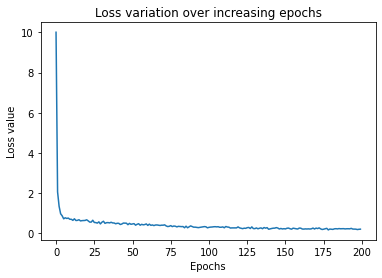

In [11]:
plt.plot(Loss)
plt.title('Loss variation over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.show()

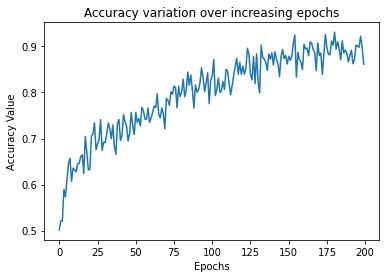

In [12]:
plt.plot(Accuracy)
plt.title('Accuracy variation over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Value')
plt.show()

## Prediction 1

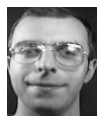

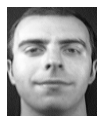

In [13]:
img_1_path = '/content/data/faces/training/s19/2.pgm'
img_2_path = '/content/data/faces/training/s19/4.pgm'

img_1 = read(img_1_path)
img_2 = read(img_2_path)

show(img_1)
show(img_2)

img_1 = val_tfms(img_1)
img_1 = img_1.view(-1, 1, 100, 100)
img_2 = val_tfms(img_2)
img_2 = img_2.view(-1, 1, 100, 100)

In [14]:
model.eval()
start = time.time()
output_1, output_2 = model(img_1.cuda(), img_2.cuda())
euclidean_distance = F.pairwise_distance(output_1, output_2)
end = time.time()
print(euclidean_distance.item())
print("Time", end-start)

0.3034992218017578
Time 0.008400917053222656


## Prediction 2

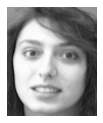

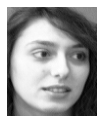

In [15]:
img_1_path = '/content/data/faces/training/s8/1.pgm'
img_2_path = '/content/data/faces/training/s8/4.pgm'

img_1 = read(img_1_path)
img_2 = read(img_2_path)

show(img_1)
show(img_2)

img_1 = val_tfms(img_1)
img_1 = img_1.view(-1, 1, 100, 100)
img_2 = val_tfms(img_2)
img_2 = img_2.view(-1, 1, 100, 100)

In [16]:
model.eval()

start = time.time()
output_1, output_2 = model(img_1.cuda(), img_2.cuda())
euclidean_distance = F.pairwise_distance(output_1, output_2)
end = time.time()
print(euclidean_distance.item())
print("Time", end-start)

0.6921433806419373
Time 0.0070607662200927734


## Prediction 3

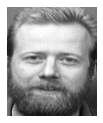

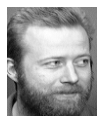

In [17]:
img_1_path = '/content/data/faces/training/s26/1.pgm'
img_2_path = '/content/data/faces/training/s26/10.pgm'

img_1 = read(img_1_path)
img_2 = read(img_2_path)

show(img_1)
show(img_2)

img_1 = val_tfms(img_1)
img_1 = img_1.view(-1, 1, 100, 100)
img_2 = val_tfms(img_2)
img_2 = img_2.view(-1, 1, 100, 100)

In [18]:
model.eval()

start = time.time()
output_1, output_2 = model(img_1.cuda(), img_2.cuda())
euclidean_distance = F.pairwise_distance(output_1, output_2)
end = time.time()
print(euclidean_distance.item())
print("Time", end-start)

0.3352404832839966
Time 0.005343437194824219


## Prediction 4

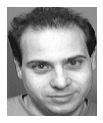

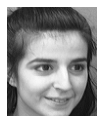

In [19]:
img_1_path = '/content/data/faces/training/s9/5.pgm'
img_2_path = '/content/data/faces/training/s10/4.pgm'

img_1 = read(img_1_path)
img_2 = read(img_2_path)

show(img_1)
show(img_2)

img_1 = val_tfms(img_1)
img_1 = img_1.view(-1, 1, 100, 100)
img_2 = val_tfms(img_2)
img_2 = img_2.view(-1, 1, 100, 100)

In [20]:
model.eval()

start = time.time()
output_1, output_2 = model(img_1.cuda(), img_2.cuda())
euclidean_distance = F.pairwise_distance(output_1, output_2)
end = time.time()
print(euclidean_distance.item())
print("Time", end-start)

1.7962335348129272
Time 0.0088653564453125
